# Import configuration and setup

In [1]:
from medulloblastoma.config import PROJ_ROOT, RAW_DATA_DIR, INTERIM_DATA_DIR, PROCESSED_DATA_DIR, EXTERNAL_DATA_DIR, MODELS_DIR, REPORTS_DIR, FIGURES_DIR
import os
import numpy as np
import pandas as pd
os.chdir(PROJ_ROOT)
from medulloblastoma.dataset import download_data, prepare_data
from medulloblastoma.features import main as preprocess_pipeline
from medulloblastoma.features import load_data
# Execute R script for GSE85217 data download
# ! Rscript {os.path.join(PROJ_ROOT, 'medulloblastoma','get_data.R')}

2025-12-13 17:28:53.602 | INFO     | medulloblastoma.config:<module>:11 - PROJ_ROOT path is: /home/edgar/VsCodeRepos/bitsxlamarato-medulloblastoma


# Prepare Data

In [ ]:
# Download microarray gene expression data
download_data(save_path=RAW_DATA_DIR,remove_gz=True)

2025-12-13 15:37:01.916 | INFO     | medulloblastoma.dataset:download_data:77 - Downloading GSE85217 dataset from GEO...
Downloading: 0.3%

KeyboardInterrupt: 

In [4]:
# Structure data so that it is easier to handle
prepare_data(
    expression_file=os.path.join(RAW_DATA_DIR,'GSE85217_M_exp_763_MB_SubtypeStudy_TaylorLab.txt'),
    metadata_path = os.path.join(RAW_DATA_DIR,'GSE85217_metadata.csv'),
    save_path=RAW_DATA_DIR
)

2025-12-13 10:41:57.581 | INFO     | medulloblastoma.dataset:prepare_data:178 - Loading gene expression data from /Users/arnaucasau/Documents/fib/Master/bitsxlamarato/bitsxlamarato-medulloblastoma/data/raw/GSE85217_M_exp_763_MB_SubtypeStudy_TaylorLab.txt
2025-12-13 10:41:58.981 | INFO     | medulloblastoma.dataset:prepare_data:183 - Loaded expression data with shape: (21641, 767)
2025-12-13 10:41:58.982 | INFO     | medulloblastoma.dataset:prepare_data:188 - Extracting gene correspondence information...
2025-12-13 10:41:59.015 | INFO     | medulloblastoma.dataset:prepare_data:192 - Expression data after removing gene info: (21641, 763)
2025-12-13 10:41:59.015 | INFO     | medulloblastoma.dataset:prepare_data:195 - Loading metadata from /Users/arnaucasau/Documents/fib/Master/bitsxlamarato/bitsxlamarato-medulloblastoma/data/raw/GSE85217_metadata.csv
2025-12-13 10:41:59.023 | INFO     | medulloblastoma.dataset:prepare_data:200 - Loaded metadata with shape: (763, 37)
2025-12-13 10:41:59.02

('/Users/arnaucasau/Documents/fib/Master/bitsxlamarato/bitsxlamarato-medulloblastoma/data/raw/cavalli.csv',
 '/Users/arnaucasau/Documents/fib/Master/bitsxlamarato/bitsxlamarato-medulloblastoma/data/raw/cavalli_subgroups.csv')

# Preprocessing

Selecting genes that are lowly expressed, lowly variant, and outlier genes. We also check that there are no missing data.

In [3]:
preprocess_pipeline(
    data_path=os.path.join(RAW_DATA_DIR,'cavalli.csv'),
    metadata_path=os.path.join(RAW_DATA_DIR,'cavalli_subgroups.csv'),
    save_path=PROCESSED_DATA_DIR,
    per=0.2,
    cutoff=0.1,
    alpha=0.05,
    outlier_method="other"
)

Path to save data: /home/edgar/VsCodeRepos/bitsxlamarato-medulloblastoma/data/processed
2025-12-13 15:37:10.777 | INFO     | medulloblastoma.features:load_data:84 - Loading data from /home/edgar/VsCodeRepos/bitsxlamarato-medulloblastoma/data/raw/cavalli.csv
2025-12-13 15:37:13.462 | INFO     | medulloblastoma.features:load_data:87 - Loading metadata from /home/edgar/VsCodeRepos/bitsxlamarato-medulloblastoma/data/raw/cavalli_subgroups.csv
2025-12-13 15:37:13.465 | INFO     | medulloblastoma.features:load_data:91 - Initial data shape: (21641, 763), metadata shape: (763,)
2025-12-13 15:37:13.465 | INFO     | medulloblastoma.features:load_data:94 - Transposing data to match metadata dimensions
2025-12-13 15:37:13.465 | SUCCESS  | medulloblastoma.features:load_data:106 - Successfully loaded data: (763, 21641) samples × 21641 features
Shape of original data: (763, 21641)
null in data: 0
na in data: 0
Are all values in the data real? Yes
2025-12-13 15:37:16.225 | INFO     | medulloblastoma.fe

KeyboardInterrupt: 

<Figure size 700x500 with 0 Axes>

<Figure size 700x500 with 0 Axes>

<Figure size 700x500 with 0 Axes>

In [28]:
# Load preprocessed gene expression data
PREPRO_TYPE = "statistical"
data=pd.read_csv(os.path.join(PROCESSED_DATA_DIR,f'cavalli_{PREPRO_TYPE}.csv'),index_col=0)

In [29]:
# Load metadata
metadata=pd.read_csv(os.path.join(RAW_DATA_DIR,'cavalli_subgroups.csv'),index_col=0).squeeze()
# Adapt names of groups of interests so they are shorter
metadata=metadata.map({'Group3':'G3','Group4':'G4'})
metadata.name = 'Subgroup'
# Select groups of interest in metedata
metadata_g3g4=metadata[metadata.isin(['G3','G4'])]
print(metadata.shape,metadata_g3g4.shape)

(763,) (470,)


In [30]:
# Select groups of interest in gene expression data
data_g3g4 = data.loc[metadata_g3g4.index]
print(data_g3g4.shape)

(470, 14403)


In [5]:
metadata.value_counts()

Subgroup
G4    326
G3    144
Name: count, dtype: int64

In [6]:
metadata_g3g4.value_counts()

Subgroup
G4    326
G3    144
Name: count, dtype: int64

In [10]:
# # Load final datasets
# data,metadata=load_data(
#     data_path=os.path.join(PROCESSED_DATA_DIR,'cavalli_maha.csv'),
#     metadata_path=os.path.join(PROCESSED_DATA_DIR,'g3g4_maha.csv')
# )
# print(data.shape,metadata.shape)

# UMAP Visualization of Preprocessed Data

In [31]:
from medulloblastoma.plots import plot_umap_binary

# Discrete color mapping for G3/G4 subtypes
dict_medulloblastoma = {
    'G3': 'red',  # Red for G3
    'G4': 'blue'   # Blue for G4
}

# Generate UMAP with discrete subtype coloring
plot_umap_binary(
    data=data_g3g4,
    clinical=metadata_g3g4,
    colors_dict=dict_medulloblastoma,
    n_components=2,
    seed=2023,
    title="Medulloblastoma G3/G4 Gene Expression UMAP",
    marker_size=20
)

X_umap.shape (470, 2)
color_series.shape (470,)
len(all_patients) 470
color_series.loc[all_patients].values.shape (470,)


# Model Training and Reconstruction

In [ ]:
# BLANK SECTION FOR MODEL TRAINING
# This section will be implemented during the hackathon
# Plan for:
# - CVAE architecture definition
# - Training loop with G3/G4 labels
# - Hyperparameter optimization
# - Model evaluation and validation
# Clue: for architecture and hyperparameter optimization, you can use ax (see https://ax.dev/)

# Imports:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Custom functions:
from medulloblastoma.modeling.train_model import *

# Parameters:
ch_batch_size = 128
loss = 'mse'

# Cycle-annealing hyperparameters:
ch_epochs = 200
ch_cycles = 3
ch_width = 80
ch_reduction = 20
ch_beta = 1

# Number of stages of cancer; this will be used by the classifier in VAE_clinical
num_classes = 4

# path_rnaseq = os.path.join(PROCESSED_DATA_DIR,'cavalli_statistical.csv')
# path_clinical = os.path.join(RAW_DATA_DIR,'cavalli_subgroups.csv')
mid_dim = 1024
features = 32
lr = 1e-4

from datetime import datetime
today = datetime.today().strftime('%Y%m%d')

from medulloblastoma.modeling.my_model import *

model_type = 'VAE'

save_model_path =os.path.join(MODELS_DIR, f'{PREPRO_TYPE}/{today}_VAE_model')
os.makedirs(save_model_path, exist_ok=True)

name=f'retraining_md{mid_dim}_f{features}_lr{lr}'
for lr in [1e-3, 1e-4, 1e-5]:
    for mid_dim in [256, 512, 1024, 2048, 4096]:
        for features in [8, 16, 32]:
            save_path = os.path.join(MODELS_DIR, f'{PREPRO_TYPE}/{today}_VAE_retraining_md{mid_dim}_f{features}_lr{lr}')
            os.makedirs(save_path, exist_ok=True)
            
            print(f'Training VAE with lr: {lr}, mid_dim: {mid_dim}, f: {features}...')
            train_data, train_loader, test_data, test_loader, loader_train_clinical, loader_test_clinical = data2tensor(
                rnaseq = data_g3g4,
                clinical = metadata_g3g4,
                batch_size = ch_batch_size,
                save_path=save_path,
            )

            input_dim = train_data.shape[0]
            num_patients = train_data.shape[1]+test_data.shape[1]
            print('Data Preprocessing successfully')

            print('input_dim =\t',input_dim)
            print('mid_dim =\t',mid_dim)
            print('features =\t',features)
            print('lr =\t',lr)
            print('num_patients =\t',num_patients)
            print('num_classes =\t',num_classes)

            # Initialize model:
            chosen_model = VAE(
                input_dim=input_dim,
                mid_dim=mid_dim,
                features=features,
            )

            (model_path, tr_l, tt_l, tr_kl, tt_kl, tr_r, tt_r, tt_dev) = cyclical_training(
                save_path=save_model_path,
                model=chosen_model,
                loader_train=train_loader,
                loader_test=test_loader,
                epochs=ch_epochs,
                cycles=ch_cycles,
                initial_width=ch_width,
                reduction=ch_reduction,
                beta=ch_beta,
                option=loss,
                learning_rate=lr,
                class_data_train=loader_train_clinical,
                class_data_test=loader_test_clinical,
                save_model=True,
                model_type=model_type
            )

            # Draw and save loss plots:
            loss_plots(
                save_path=save_path,
                train_loss=tr_l,
                test_loss=tt_l,
                kl_loss_train=tr_kl,
                kl_loss_test=tt_kl,
                rec_loss_train=tr_r,
                rec_loss_test=tt_r,
            )

Training VAE with lr: 0.001, mid_dim: 256, f: 8...
The shape of the train data is (genes: features, patients: samples):  (14403, 376)
The shape of the test data is (genes: features, patients: samples):  (14403, 94)
Data will be transposed when calling DataLoader to get (samples, features) shape
DataLoader created
len(loader_test.dataset)= 94
DataLoader "normal" created
len(loader_test.dataset)= 94
len(loader_train.dataset)= 376
loader_test=	 <torch.utils.data.dataloader.DataLoader object at 0x78c46f033820>
loader_train=	 <torch.utils.data.dataloader.DataLoader object at 0x78c46f0a9a90>
loader_train.dataset.shape=	 torch.Size([376, 14403])
loader_test.dataset.shape=	 torch.Size([94, 14403])
Data Preprocessing successfully
input_dim =	 14403
mid_dim =	 256
features =	 8
lr =	 0.001
num_patients =	 470
num_classes =	 4
Starting Cycle  0


100%|██████████| 200/200 [00:14<00:00, 13.38it/s]


Starting Cycle  1


100%|██████████| 200/200 [00:14<00:00, 13.36it/s]


Starting Cycle  2


100%|██████████| 200/200 [00:15<00:00, 12.90it/s]


Trained VAE model saved as /home/edgar/VsCodeRepos/bitsxlamarato-medulloblastoma/models/statistical/20251213_VAE_model/20251213_VAE_idim14403_md256_feat8_lr0.001.pth
Training VAE with lr: 0.001, mid_dim: 256, f: 16...
The shape of the train data is (genes: features, patients: samples):  (14403, 376)
The shape of the test data is (genes: features, patients: samples):  (14403, 94)
Data will be transposed when calling DataLoader to get (samples, features) shape
DataLoader created
len(loader_test.dataset)= 94
DataLoader "normal" created
len(loader_test.dataset)= 94
len(loader_train.dataset)= 376
loader_test=	 <torch.utils.data.dataloader.DataLoader object at 0x78c63a7b79b0>
loader_train=	 <torch.utils.data.dataloader.DataLoader object at 0x78c603669940>
loader_train.dataset.shape=	 torch.Size([376, 14403])
loader_test.dataset.shape=	 torch.Size([94, 14403])
Data Preprocessing successfully
input_dim =	 14403
mid_dim =	 256
features =	 16
lr =	 0.001
num_patients =	 470
num_classes =	 4
Star

100%|██████████| 200/200 [00:15<00:00, 13.29it/s]


Starting Cycle  1


100%|██████████| 200/200 [00:13<00:00, 14.92it/s]


Starting Cycle  2


100%|██████████| 200/200 [00:13<00:00, 14.42it/s]


Trained VAE model saved as /home/edgar/VsCodeRepos/bitsxlamarato-medulloblastoma/models/statistical/20251213_VAE_model/20251213_VAE_idim14403_md256_feat16_lr0.001.pth
Training VAE with lr: 0.001, mid_dim: 256, f: 32...
The shape of the train data is (genes: features, patients: samples):  (14403, 376)
The shape of the test data is (genes: features, patients: samples):  (14403, 94)
Data will be transposed when calling DataLoader to get (samples, features) shape
DataLoader created
len(loader_test.dataset)= 94
DataLoader "normal" created
len(loader_test.dataset)= 94
len(loader_train.dataset)= 376
loader_test=	 <torch.utils.data.dataloader.DataLoader object at 0x78c48cd37bd0>
loader_train=	 <torch.utils.data.dataloader.DataLoader object at 0x78c48ca79d00>
loader_train.dataset.shape=	 torch.Size([376, 14403])
loader_test.dataset.shape=	 torch.Size([94, 14403])
Data Preprocessing successfully
input_dim =	 14403
mid_dim =	 256
features =	 32
lr =	 0.001
num_patients =	 470
num_classes =	 4
Sta

100%|██████████| 200/200 [00:13<00:00, 14.98it/s]


Starting Cycle  1


100%|██████████| 200/200 [00:11<00:00, 17.67it/s]


Starting Cycle  2


100%|██████████| 200/200 [00:09<00:00, 20.37it/s]


Trained VAE model saved as /home/edgar/VsCodeRepos/bitsxlamarato-medulloblastoma/models/statistical/20251213_VAE_model/20251213_VAE_idim14403_md256_feat32_lr0.001.pth
Training VAE with lr: 0.001, mid_dim: 512, f: 8...
The shape of the train data is (genes: features, patients: samples):  (14403, 376)
The shape of the test data is (genes: features, patients: samples):  (14403, 94)
Data will be transposed when calling DataLoader to get (samples, features) shape
DataLoader created
len(loader_test.dataset)= 94
DataLoader "normal" created
len(loader_test.dataset)= 94
len(loader_train.dataset)= 376
loader_test=	 <torch.utils.data.dataloader.DataLoader object at 0x78c48cd37790>
loader_train=	 <torch.utils.data.dataloader.DataLoader object at 0x78c48cd378a0>
loader_train.dataset.shape=	 torch.Size([376, 14403])
loader_test.dataset.shape=	 torch.Size([94, 14403])
Data Preprocessing successfully
input_dim =	 14403
mid_dim =	 512
features =	 8
lr =	 0.001
num_patients =	 470
num_classes =	 4
Start

100%|██████████| 200/200 [00:11<00:00, 17.15it/s]


Starting Cycle  1


 42%|████▏     | 84/200 [00:05<00:07, 16.25it/s]

my_path: /home/edgar/VsCodeRepos/bitsxlamarato-medulloblastoma/models/maha
Minimum test loss found: 6.542725258685172
Minimum test loss found for: md=256, f=32, lr=0.001


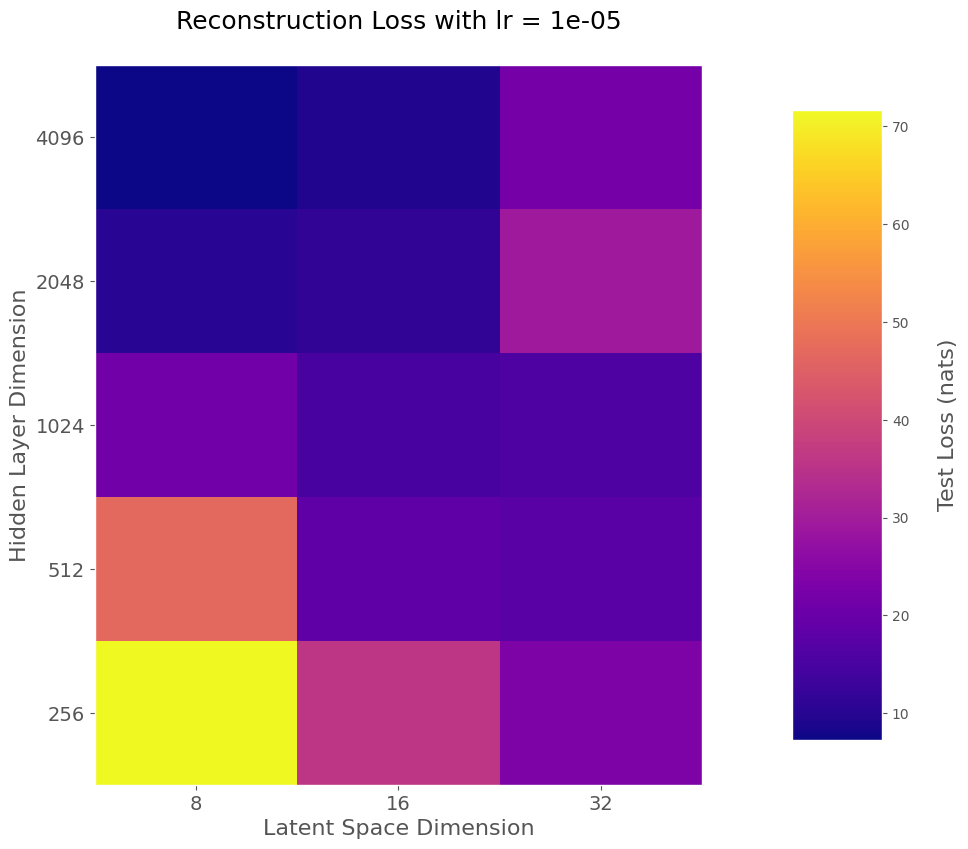

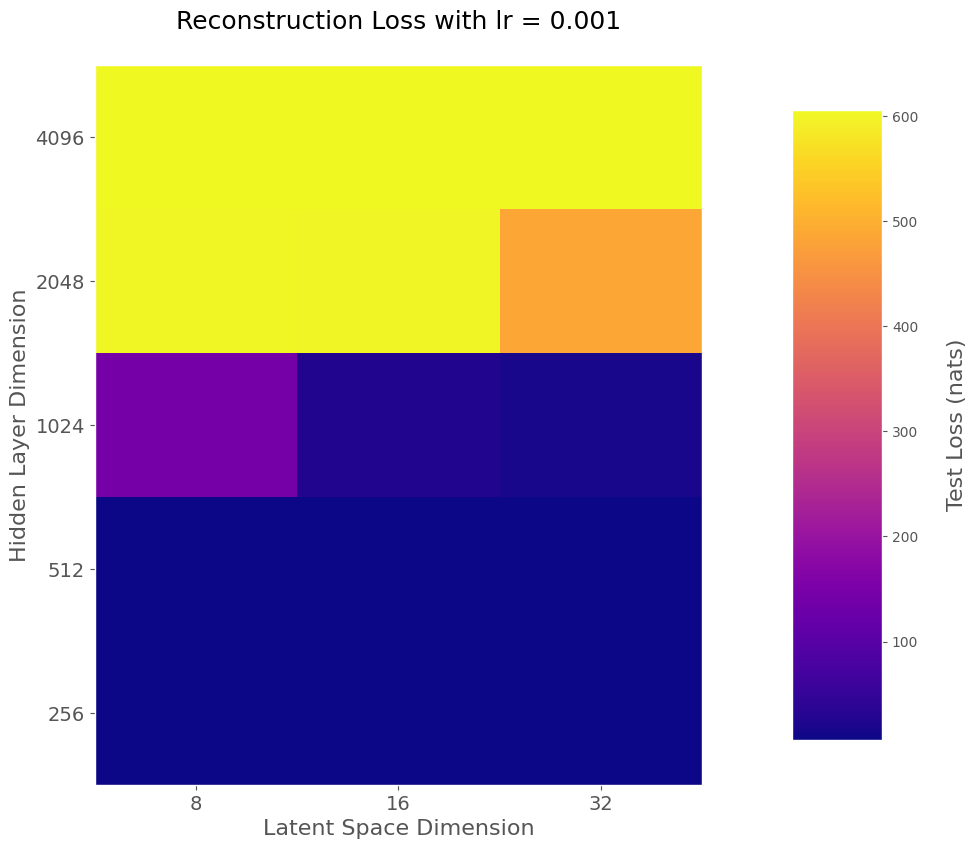

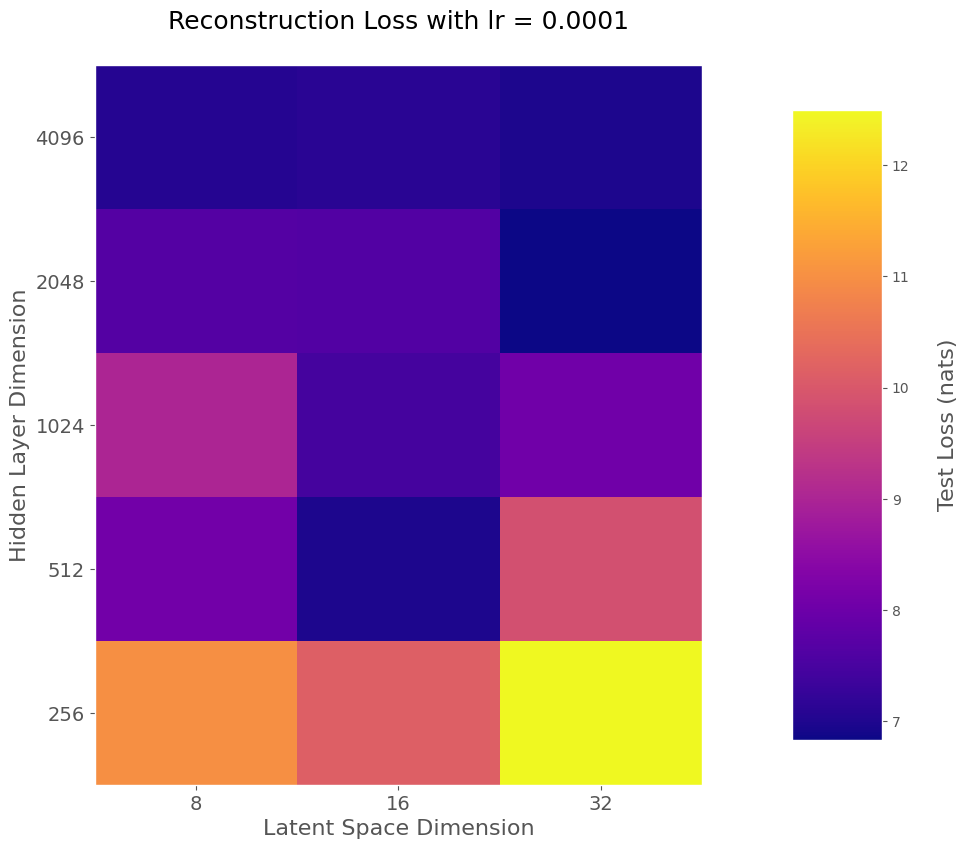

In [6]:
from medulloblastoma.modeling.check_model import main as check_model

best_df = check_model(
    save_path=os.path.join(MODELS_DIR, PREPRO_TYPE),
    rnaseq=data_g3g4,
    clinical=metadata_g3g4
)

# Final UMAP with Continuous Scoring

In [10]:
from medulloblastoma.plots import plot_umap_spectrum
import pandas as pd
import torch
import os
from sklearn.preprocessing import MinMaxScaler

In [9]:
def check_data(data):
    # check if data is DataFrame or numpy array
    if isinstance(data, pd.DataFrame):
        data = torch.tensor(data.values).float()
    elif isinstance(data, np.ndarray):
        data = torch.tensor(data).float()
    elif isinstance(data, torch.Tensor):
        data = data.float()
    else:
        raise ValueError("data is neither a pandas DataFrame, a numpy array, nor a torch tensor")
    return data

def apply_VAE(data,model_here,y=None):
    scaler = MinMaxScaler()
    scaler.fit(data)
    data2 = scaler.transform(data)
    
    with torch.no_grad():
        if y is None:
            data_latent, mu, logvar, z = model_here(torch.tensor(data2).float())
            data_vae = scaler.inverse_transform(data_latent)
        else:
            data_latent, mu, logvar, z = model_here(torch.tensor(data2).float(),torch.tensor(y).float())
            data_vae = scaler.inverse_transform(data_latent)

    return data_vae, mu, logvar, z, scaler

In [8]:
def load_model(model_path,model,hyperparams,seed=2023):
    # Importing the model:
    set_seed(seed)
    if model.__name__ == 'VAE':
        idim, md, feat = hyperparams
        model_vae = model(input_dim=idim, mid_dim=md, features=feat)  # Initialize the model
    elif model.__name__ == 'NetworkReconstruction':
        model_vae = model(hyperparams)
    else:
        raise ValueError('Model not recognized. Must be VAE or NetworkReconstruction')
    model_vae.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))  # Load the state dictionary
    model_vae.eval()  # Set the model to evaluation mode
    return model_vae

In [ ]:
model_vae = load_model(
    # MAHA
    model_path=os.path.join(MODELS_DIR, "maha_models", "best_model.pth"),
    hyperparams=(input_dim, 256, 32),
    # STATISTICAL
    
    model=VAE,
)
data_for_model = check_data(data=data_g3g4)

decoded, mu, logvar, z, scaler = apply_VAE(data=data_for_model, model_here=model_vae, y=None)
df_decoded = pd.DataFrame(decoded, index=data_g3g4.index, columns=data.columns)
df_z = pd.DataFrame(z, index=data_g3g4.index)

mu = mu.cpu().numpy()
logvar = logvar.cpu().numpy()
sigma = np.exp(0.5 * logvar)

# Save the data
os.makedirs(save_path,exist_ok=True)
print('Saving data to:',save_path)
print('Saving latent space...')
df_z.to_csv(os.path.join(save_path,'z.csv'))
print('Done!')

Saving data to: /home/edgar/VsCodeRepos/bitsxlamarato-medulloblastoma/models/maha/20251213_VAE_retraining_md256_f8_lr0.001
Saving latent space...
Done!


In [24]:
# For testing purposes, we assign a random score between 0 and 1 to each patient
# score=pd.Series(np.random.rand(470),name='score',index=metadata_g3g4.index)
from sklearn.linear_model import LogisticRegression

y = (metadata_g3g4 == "G4").astype(int)
X_mu = mu[df_z.index.get_indexer(metadata_g3g4.index)]

logreg = LogisticRegression(
    penalty="l2",
    C=1.0,
    solver="lbfgs",
    max_iter=10000,
    random_state=16,
    verbose=1
)

logreg.fit(X_mu, y)

p = logreg.predict_proba(X_mu)[:, 1]
W = np.diag(p * (1 - p))

X_design = np.hstack([X_mu, np.ones((X_mu.shape[0], 1))])
H = X_design.T @ W @ X_design + np.eye(X_design.shape[1])

Sigma_w = np.linalg.inv(H)
w_map = np.concatenate([logreg.coef_.ravel(), logreg.intercept_])

score = pd.Series(index=metadata_g3g4.index, data=p)
print(score.head(5))

GSM2261539    0.513013
GSM2261540    0.681938
GSM2261541    0.755563
GSM2261542    0.641515
GSM2261545    0.369723
dtype: float64


In [25]:
def bayesian_predict(mu, sigma, w_map, Sigma_w, n_samples=200):
    N, D = mu.shape
    scores_mean = np.zeros(N)
    scores_std = np.zeros(N)

    for i in range(N):
        # sample latent variables
        z_samples = (
            mu[i]
            + sigma[i] * np.random.randn(n_samples, D)
        )

        # add bias term
        z_samples = np.hstack([
            z_samples,
            np.ones((n_samples, 1))
        ])

        # sample classifier weights
        w_samples = np.random.multivariate_normal(
            w_map,
            Sigma_w,
            size=n_samples
        )

        logits = np.sum(z_samples * w_samples, axis=1)
        probs = 1 / (1 + np.exp(-logits))

        scores_mean[i] = probs.mean()
        scores_std[i] = probs.std()

    return scores_mean, scores_std

In [26]:
X_mu_all = mu[df_z.index.get_indexer(metadata_g3g4.index)]
X_sigma_all = sigma[df_z.index.get_indexer(metadata_g3g4.index)]

score_mean, score_std = bayesian_predict(
    X_mu_all,
    X_sigma_all,
    w_map,
    Sigma_w,
    n_samples=300
)

score = pd.Series(
    score_mean,
    index=metadata_g3g4.index,
    name="P(G3)"
)

uncertainty = pd.Series(
    score_std,
    index=metadata_g3g4.index,
    name="uncertainty"
)


In [27]:
plot_umap_spectrum(
    data=data_g3g4,
    clinical=score,  # Continuous scores instead of discrete labels
    colormap='RdBu',
    n_components=2,
    seed=2023,
    title="Medulloblastoma G3/G4 Scores",
    marker_size=20
)

X_umap.shape (470, 2)
color_series.shape (470,)
color_series range: [0.341, 0.666]
len(all_patients) 470
